<a href="https://colab.research.google.com/github/MortezaMahdaviMortazavi/DeepLearning-Introduction/blob/master/GAN/HandWrittenDigitsGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader,ConcatDataset

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUM_EPOCHES = 50
Z_DIM = 64 # 128 , 256
BATCH_SIZE = 64
LATENT_DIM = 100
IMG_DIM = 28 * 28 * 1
IMG_SHAPE = (1,28,28)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FIX_NOISE = torch.randn((BATCH_SIZE,Z_DIM)).to(DEVICE)
LEARNING_RATE = 3e-4
TRANSFORM = T.Compose([
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [ ]:
class DataHandler:
  def __init__(self,path,transform,download=True):
    self.trainset = torchvision.datasets.MNIST(
        root=path,
        train=True,
        download=download,
        transform=transform,
    )
    self.testset = torchvision.datasets.MNIST(
        root=path,
        train=False,
        download=download,
        transform=transform,
    )
  def __call__(self):
    concat_dataset = ConcatDataset([self.trainset,self.testset])
    dataloader = DataLoader(concat_dataset,batch_size=BATCH_SIZE,shuffle=True)
    return dataloader

In [ ]:
class BCECost(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_preds, y_labels):
        epsilon = 1e-8  # add a small epsilon to prevent taking the log of zero
        loss = -torch.mean(y_labels * torch.log(y_preds + epsilon) + (1 - y_labels) * torch.log(1 - y_preds + epsilon))
        return loss


In [ ]:
class GANLoss:
  def __init__(self):
    self.bce_loss = BCECost()

  def __call__(self,fake_output,real_output):
    generator_loss = self.bce_loss(fake_output,torch.ones_like(fake_output))
    discriminator_loss = self.bce_loss(fake_output,torch.ones_like(fake_output)) + self.bce_loss(real_output,torch.ones_like(real_output))
    return generator_loss , discriminator_loss

In [ ]:
class Trainer:
  def __init__(self,generator,discriminator):
    self.gen = generator.to(DEVICE)
    self.disc = discriminator.to(DEVICE)
    self.dataloader = DataHandler(path='./data',transform=TRANSFORM)()
    self.process_after_epochs = 50 # show results after each 50 epoches
    self.loss_after_epochs = 10 # show loss after each 10 epoches

  def setEquip(self):
    self.opt_disc = torch.optim.Adam(self.disc.parameters(),lr=LEARNING_RATE,capturable=True)
    self.opt_gen = torch.optim.Adam(self.gen.parameters(),lr=LEARNING_RATE,capturable=True)
    self.loss = nn.BCELoss()

  def get_out_plot(self, fake_images, real_images, num_samples=10):
      sample_indices = torch.randint(BATCH_SIZE, size=(num_samples,))
      real_images_sample = real_images[sample_indices].cpu()
      fake_images_sample = fake_images[sample_indices].cpu()
      # plot the real and fake images side by side
      fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
      for i in range(num_samples):
          axes[0, i].imshow(real_images_sample[i].permute(1, 2, 0))
          axes[0, i].set_title("Real Image")
          axes[1, i].imshow(fake_images_sample[i].permute(1, 2, 0))
          axes[1, i].set_title("Fake Image")
      plt.show()


  def train(self):
    flag = True
    for epoch in range(1,NUM_EPOCHES+1):
      for batch_idx , (real,_) in enumerate(self.dataloader):
        # real = real.view(-1,784).to(DEVICE)
        real = real.to(DEVICE)
        batch_size = real.shape[0]

        ### train discriminator : max log(D(real)) + log(1-D(G(z)))
        noise = torch.randn(batch_size,Z_DIM)#.to(DEVICE)
        fake = self.gen(noise)
        disc_real = self.disc(real)#.view(-1)
        lossD_real = self.loss(disc_real,torch.ones_like(disc_real))
        disc_fake = self.disc(fake)#.view(-1)
        lossD_fake = self.loss(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_real+lossD_fake) / 2
        self.disc.zero_grad()
        lossD.backward(retain_graph=True)
        self.opt_disc.step()

        ### Train Generator min log(1-D(G(z))) <--> max log(D(G(z)))
        output = self.disc(fake)#.view(-1)
        lossG = self.loss(output,torch.ones_like(output))
        self.gen.zero_grad()
        lossG.backward()
        self.opt_gen.step()

        if batch_idx == 0:
          print(f"epoch {epoch}/{NUM_EPOCHES} | lossG {lossG:>.3f} | lossD {lossD:>.3f}")
        if epoch % 5 == 0 and flag:
          with torch.no_grad():
            fake = self.gen(FIX_NOISE.to(DEVICE)).reshape(-1,1,28,28)
            real = real.reshape(-1,1,28,28)
            self.get_out_plot(fake_images=fake,real_images=real)
          flag = False
      flag = True

    

  def __call__(self):
    self.setEquip()
    self.train()

In [ ]:
class FCDiscriminator(nn.Module):
  def __init__(self,in_features):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(in_features,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,128),
        nn.LeakyReLU(0.01),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
  def forward(self,img):
    return self.disc(img)

In [ ]:
class FCGenerator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim,256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,512),
        nn.LeakyReLU(0.1),
        nn.Linear(512,img_dim), # 28 * 28 = 784
        nn.Tanh()
    )

  def forward(self,img):
    return self.gen(img)


epoch 1/50 | lossG 0.733 | lossD 0.673
epoch 2/50 | lossG 2.277 | lossD 0.285
epoch 3/50 | lossG 6.245 | lossD 0.589
epoch 4/50 | lossG 1.309 | lossD 0.448
epoch 5/50 | lossG 1.564 | lossD 0.312


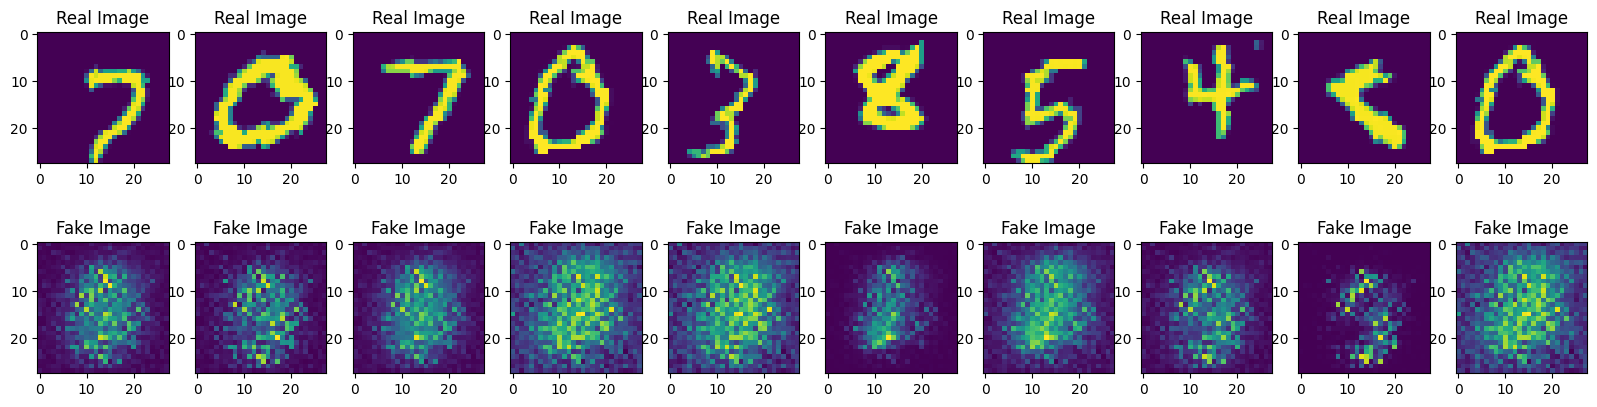

epoch 6/50 | lossG 1.509 | lossD 0.494
epoch 7/50 | lossG 1.116 | lossD 0.653
epoch 8/50 | lossG 1.620 | lossD 0.507
epoch 9/50 | lossG 2.084 | lossD 0.441
epoch 10/50 | lossG 1.819 | lossD 0.584


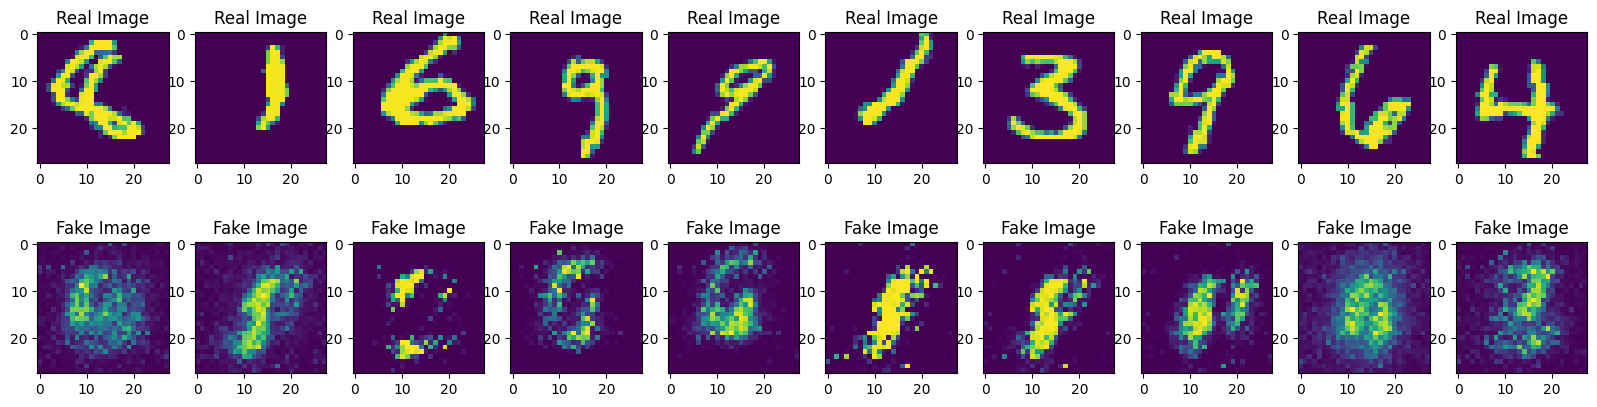

epoch 11/50 | lossG 1.208 | lossD 0.513
epoch 12/50 | lossG 1.370 | lossD 0.572
epoch 13/50 | lossG 1.599 | lossD 0.428
epoch 14/50 | lossG 1.213 | lossD 0.799
epoch 15/50 | lossG 1.431 | lossD 0.527


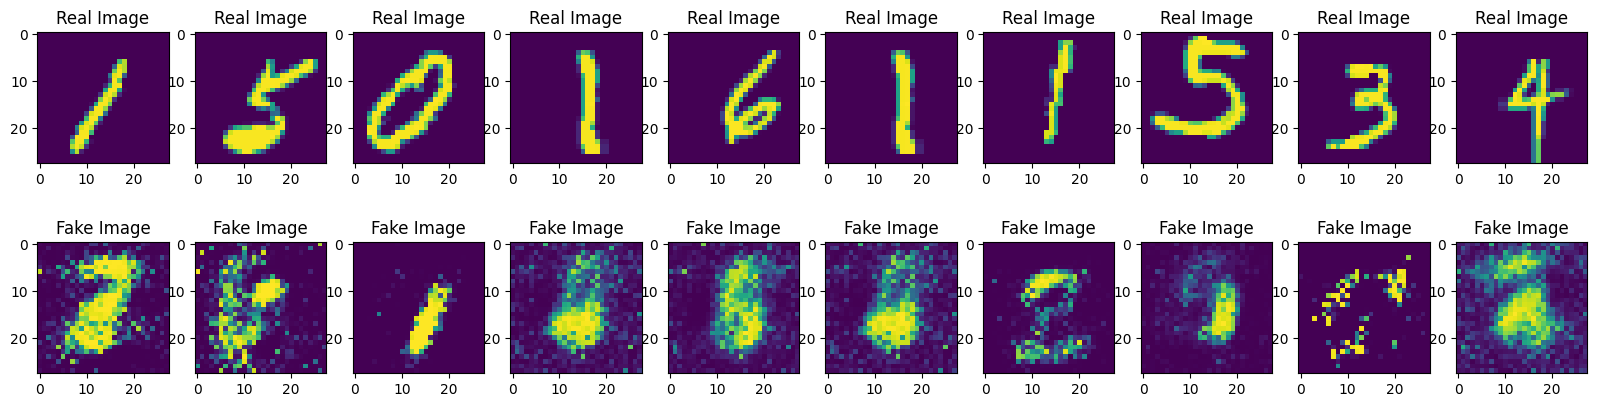

epoch 16/50 | lossG 1.360 | lossD 0.472
epoch 17/50 | lossG 2.171 | lossD 0.397
epoch 18/50 | lossG 1.577 | lossD 0.505
epoch 19/50 | lossG 1.958 | lossD 0.395
epoch 20/50 | lossG 1.801 | lossD 0.404


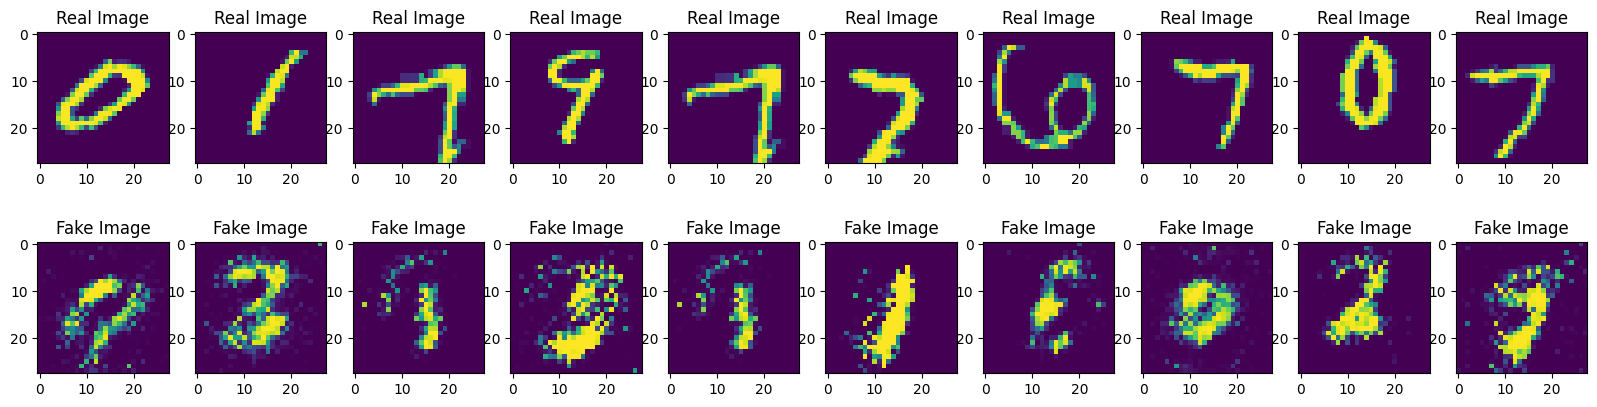

epoch 21/50 | lossG 1.343 | lossD 0.522
epoch 22/50 | lossG 1.203 | lossD 0.566
epoch 23/50 | lossG 1.278 | lossD 0.840
epoch 24/50 | lossG 1.437 | lossD 0.600
epoch 25/50 | lossG 1.299 | lossD 0.494


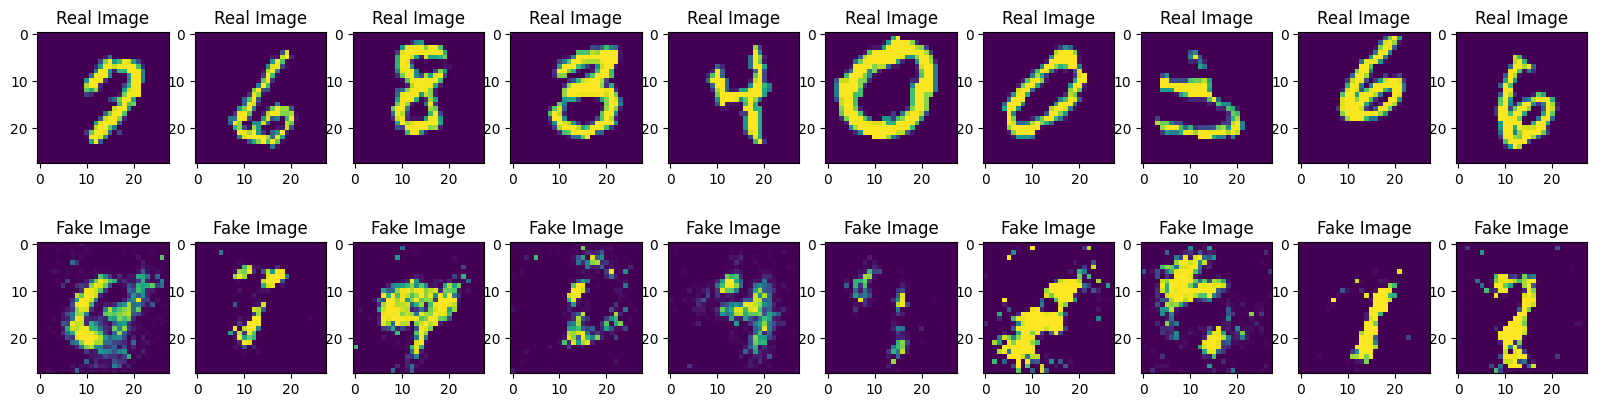

epoch 26/50 | lossG 1.323 | lossD 0.465
epoch 27/50 | lossG 1.355 | lossD 0.476
epoch 28/50 | lossG 1.208 | lossD 0.510
epoch 29/50 | lossG 1.441 | lossD 0.593
epoch 30/50 | lossG 1.409 | lossD 0.539


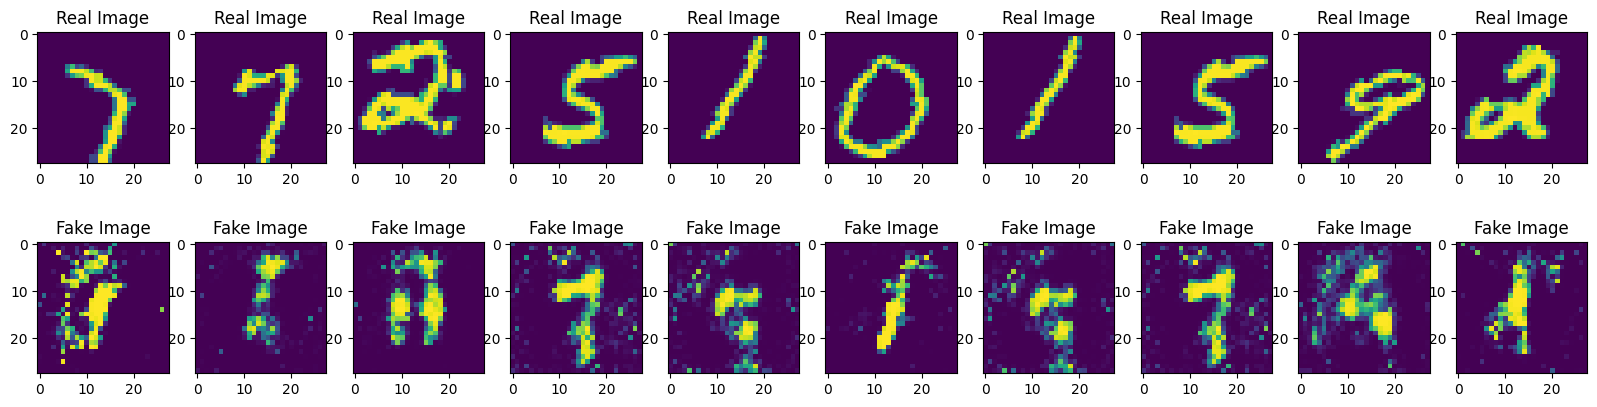

epoch 31/50 | lossG 1.302 | lossD 0.582
epoch 32/50 | lossG 1.119 | lossD 0.515
epoch 33/50 | lossG 1.484 | lossD 0.434
epoch 34/50 | lossG 1.232 | lossD 0.534
epoch 35/50 | lossG 1.246 | lossD 0.556


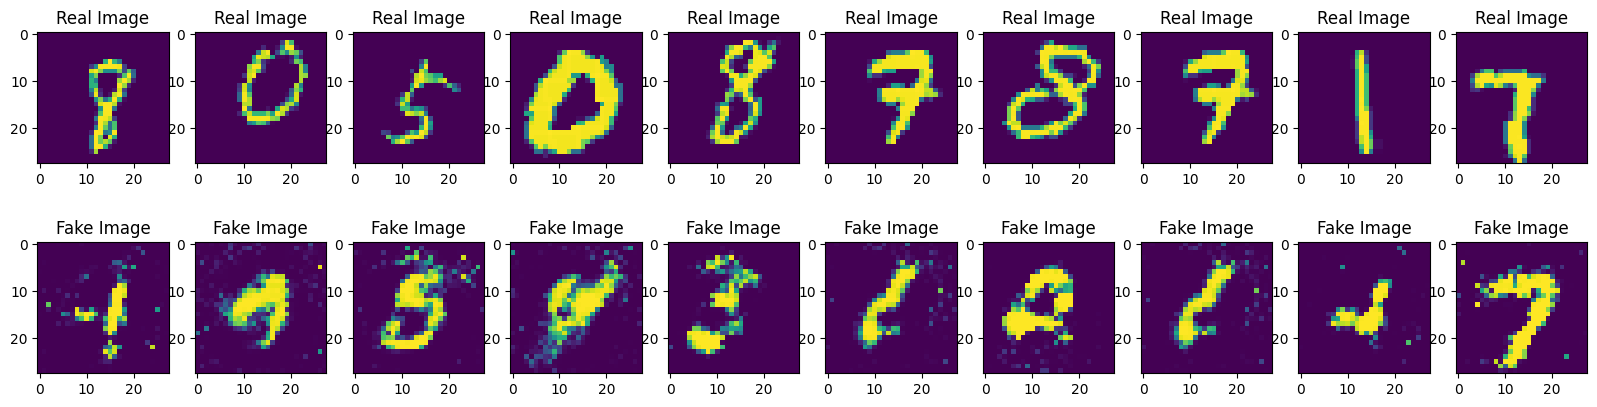

epoch 36/50 | lossG 1.057 | lossD 0.539
epoch 37/50 | lossG 1.424 | lossD 0.527
epoch 38/50 | lossG 1.160 | lossD 0.568
epoch 39/50 | lossG 1.148 | lossD 0.583
epoch 40/50 | lossG 1.071 | lossD 0.545


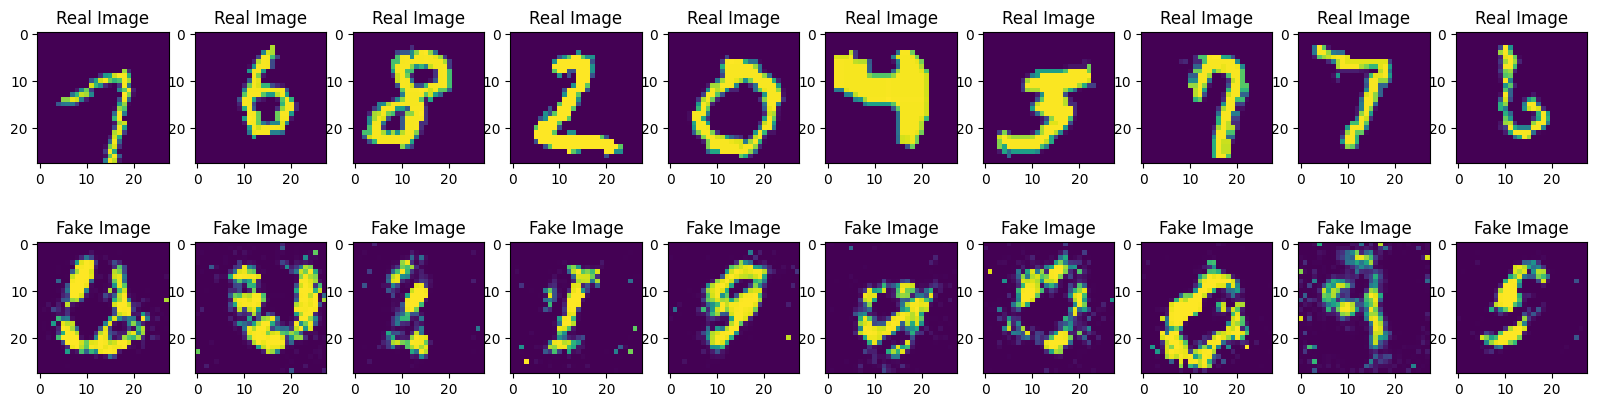

epoch 41/50 | lossG 1.034 | lossD 0.666
epoch 42/50 | lossG 1.067 | lossD 0.559
epoch 43/50 | lossG 1.115 | lossD 0.558
epoch 44/50 | lossG 1.423 | lossD 0.541
epoch 45/50 | lossG 1.006 | lossD 0.575


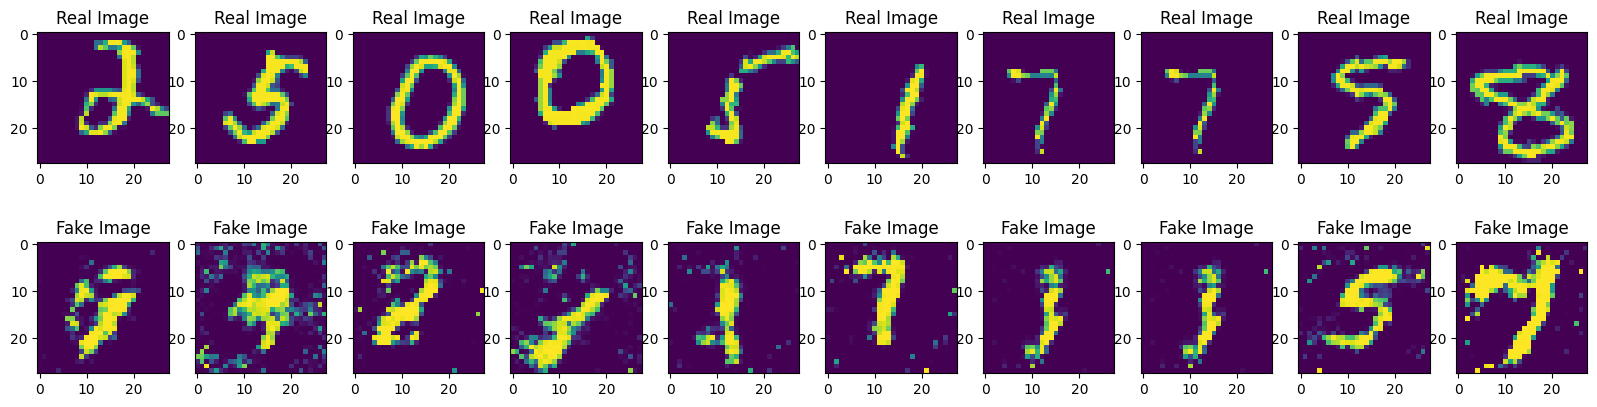

epoch 46/50 | lossG 1.053 | lossD 0.571
epoch 47/50 | lossG 1.287 | lossD 0.562
epoch 48/50 | lossG 1.030 | lossD 0.606
epoch 49/50 | lossG 1.103 | lossD 0.503
epoch 50/50 | lossG 0.999 | lossD 0.682


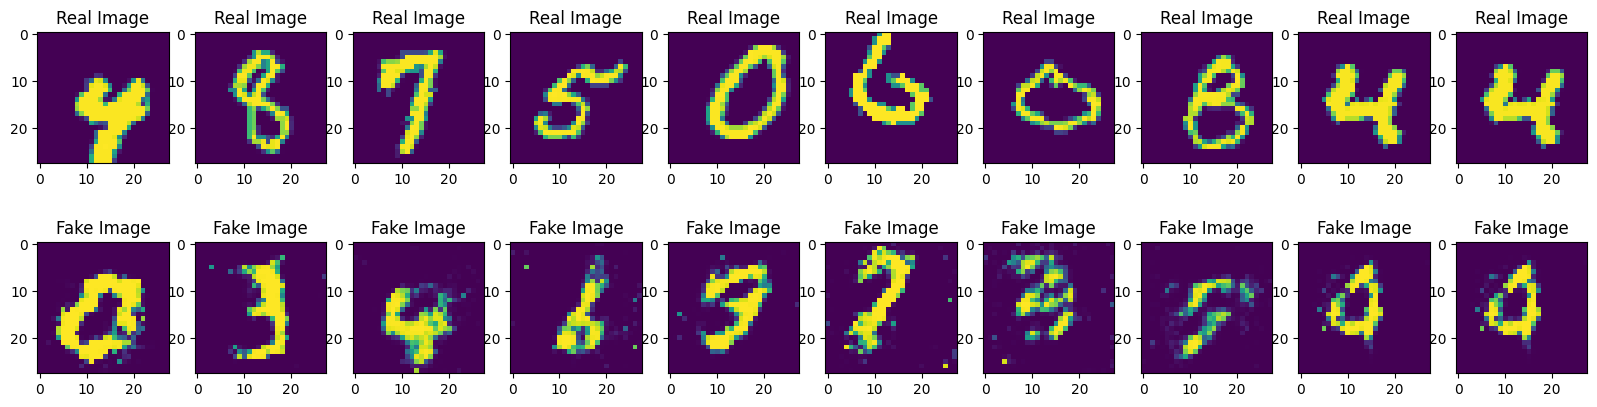

In [ ]:
fc_gen = FCGenerator(z_dim=Z_DIM,img_dim=IMG_DIM)
fc_disc = FCDiscriminator(in_features=IMG_DIM)
trainer = Trainer(
    generator=fc_gen,
    discriminator=fc_disc
)
trainer()

In [ ]:
class CNNDiscriminator(nn.Module):
    def __init__(self,in_features):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_features,
            out_channels=10,
            kernel_size=3,
            stride=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=10,
            out_channels=16,
            kernel_size=3,
            stride=1
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc = nn.Sequential(
            nn.Linear(400,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,1),
            nn.Sigmoid()
        )

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self,inp):
        out = self.conv1(inp)
        out = self.leaky_relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.leaky_relu(out)
        out = self.maxpool(out)
        out = out.view(out.shape[0],-1)
        out = self.fc(out)
        return out

epoch 1/50 | lossG 4.314 | lossD 0.356
epoch 2/50 | lossG 2.953 | lossD 0.107
epoch 3/50 | lossG 6.703 | lossD 0.001
epoch 4/50 | lossG 2.772 | lossD 0.257
epoch 5/50 | lossG 5.254 | lossD 0.007


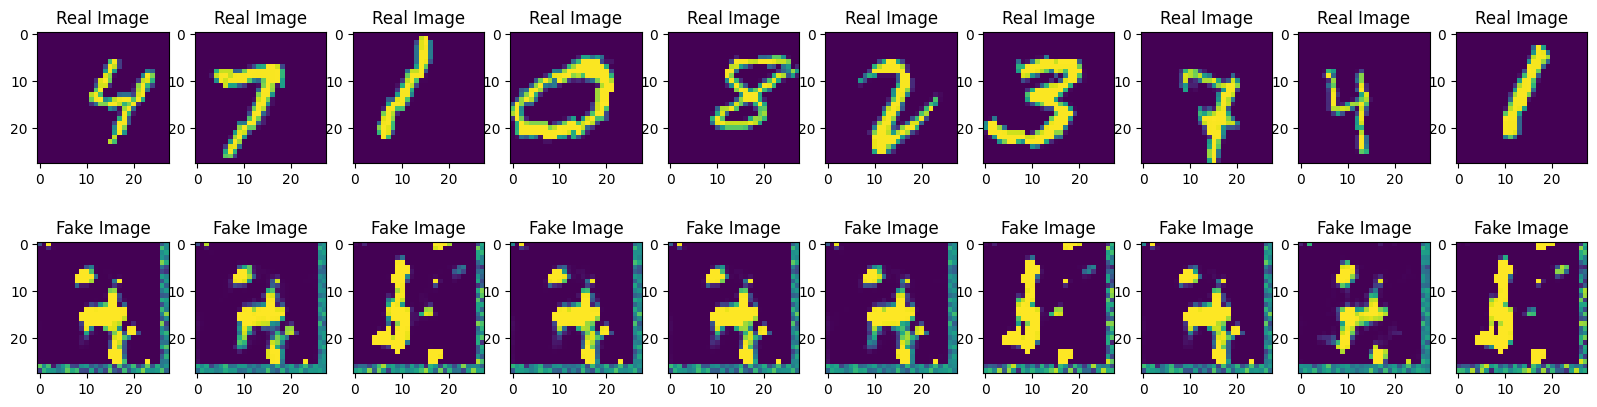

epoch 6/50 | lossG 3.025 | lossD 0.168
epoch 7/50 | lossG 4.050 | lossD 0.069
epoch 8/50 | lossG 6.192 | lossD 0.003
epoch 9/50 | lossG 3.940 | lossD 0.026
epoch 10/50 | lossG 5.824 | lossD 0.140


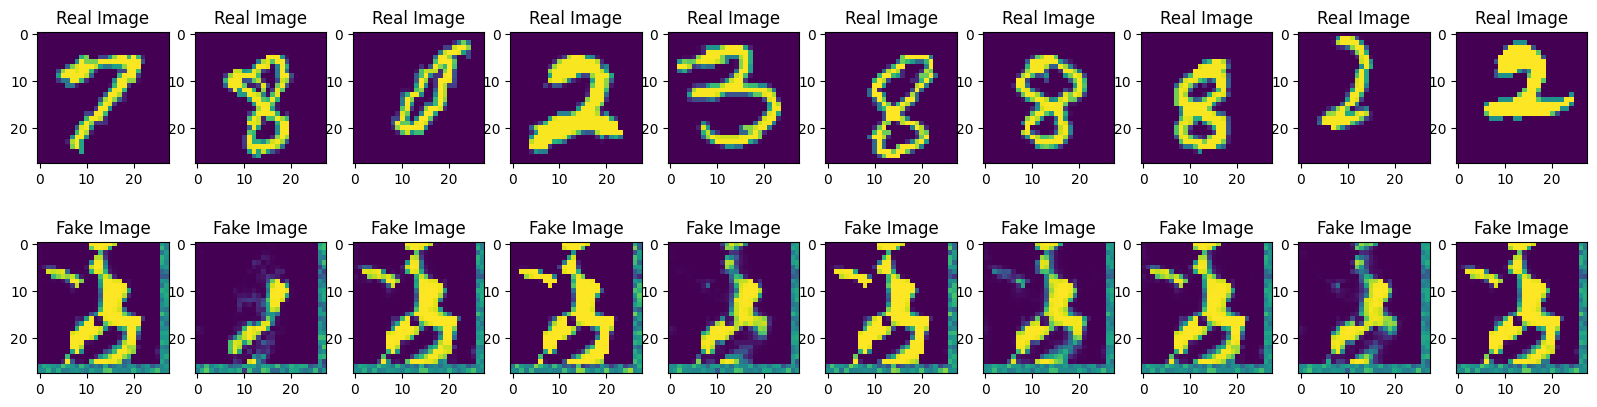

epoch 11/50 | lossG 5.872 | lossD 0.063
epoch 12/50 | lossG 7.733 | lossD 0.012
epoch 13/50 | lossG 6.169 | lossD 0.090
epoch 14/50 | lossG 5.709 | lossD 0.008
epoch 15/50 | lossG 4.459 | lossD 0.060


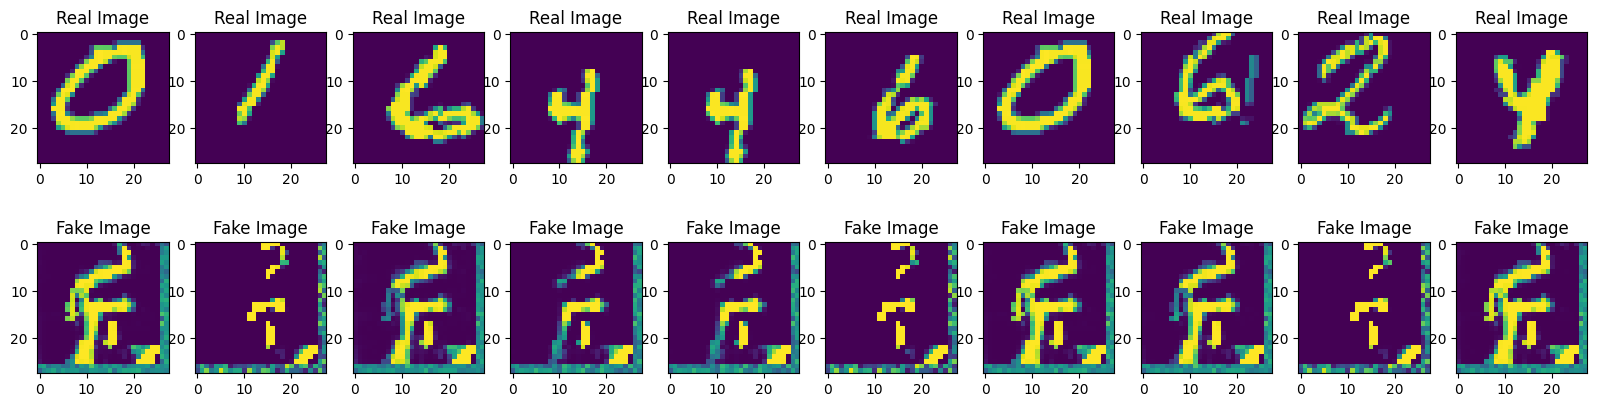

epoch 16/50 | lossG 4.846 | lossD 0.039
epoch 17/50 | lossG 5.128 | lossD 0.008
epoch 18/50 | lossG 5.621 | lossD 0.048
epoch 19/50 | lossG 7.188 | lossD 0.001
epoch 20/50 | lossG 4.489 | lossD 0.067


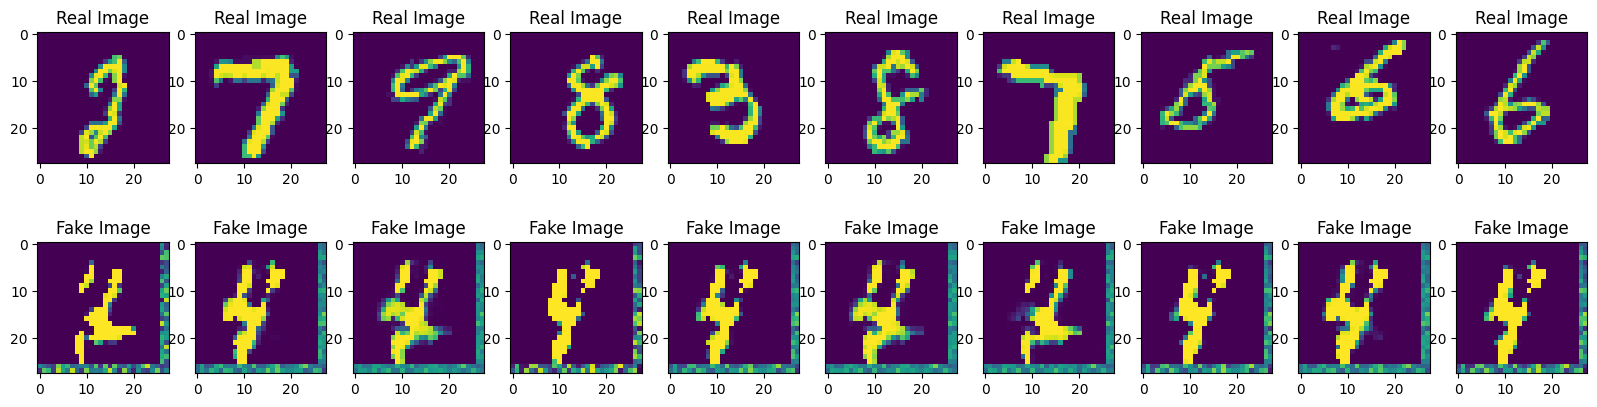

epoch 21/50 | lossG 5.291 | lossD 0.010
epoch 22/50 | lossG 6.444 | lossD 0.005
epoch 23/50 | lossG 4.287 | lossD 0.012
epoch 24/50 | lossG 4.344 | lossD 0.017
epoch 25/50 | lossG 4.725 | lossD 0.005


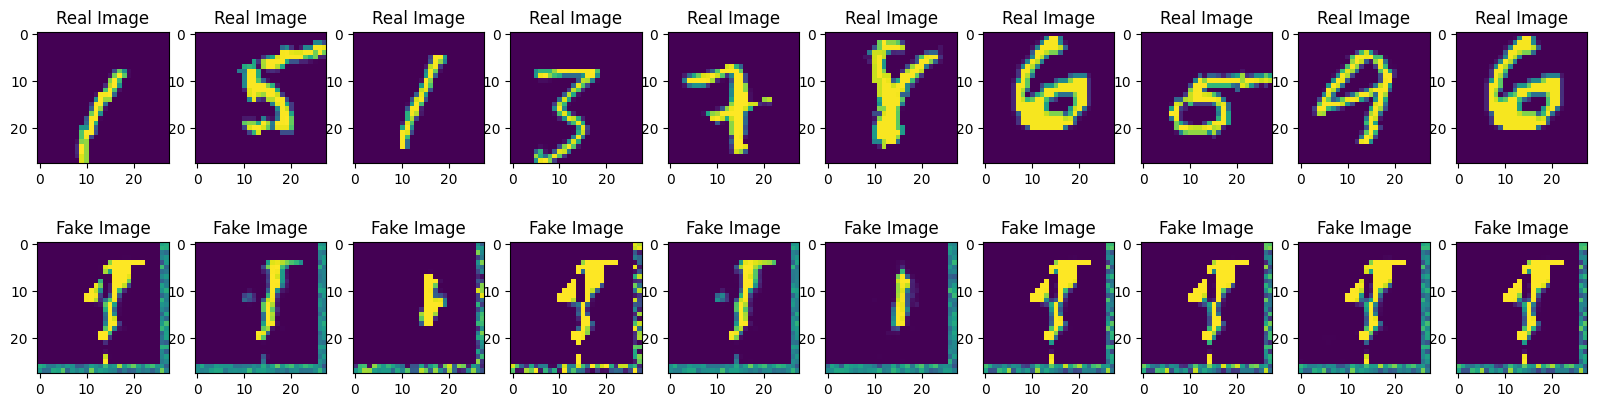

epoch 26/50 | lossG 5.901 | lossD 0.041
epoch 27/50 | lossG 5.071 | lossD 0.105
epoch 28/50 | lossG 4.983 | lossD 0.026
epoch 29/50 | lossG 2.666 | lossD 0.061
epoch 30/50 | lossG 4.996 | lossD 0.006


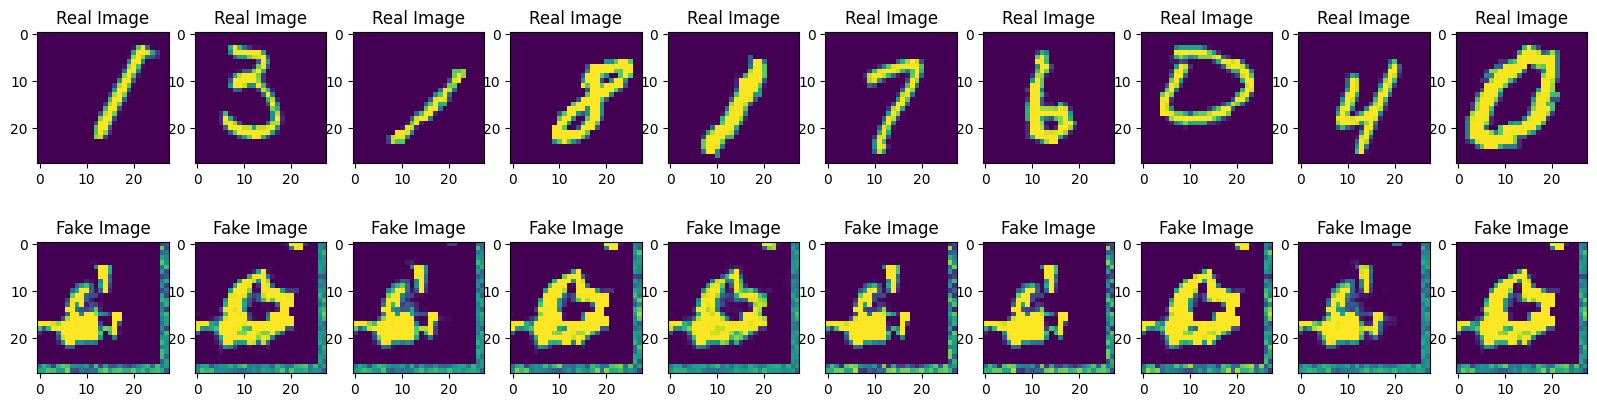

epoch 31/50 | lossG 5.014 | lossD 0.182


KeyboardInterrupt: 

In [ ]:
fc_gen = FCGenerator(z_dim=Z_DIM,img_dim=IMG_DIM)
cnn_disc = CNNDiscriminator(in_features=1)
trainer = Trainer(
    generator=fc_gen,
    discriminator=fc_disc
)
trainer()

In [ ]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        x = self.gen(x)
        return x
        

In [ ]:
x = torch.randn(10,10)
Generator()(x)

tensor([[[[ 0.2097,  0.3736,  0.4392,  ...,  0.7114, -0.2088,  0.1076],
          [ 0.0637, -0.2944, -0.7417,  ..., -0.3491, -0.3431,  0.1394],
          [-0.4915,  0.7406,  0.2818,  ...,  0.5975,  0.6447,  0.6544],
          ...,
          [-0.2749, -0.4226,  0.0393,  ...,  0.5794,  0.0251, -0.0746],
          [-0.0227,  0.5507, -0.3968,  ...,  0.7970,  0.5623, -0.3679],
          [-0.1305, -0.4296,  0.4236,  ...,  0.4357, -0.5122,  0.5180]]],


        [[[ 0.1590, -0.1426, -0.0158,  ...,  0.7238, -0.3266,  0.1439],
          [-0.0154,  0.1413, -0.3574,  ..., -0.1648, -0.0278, -0.0313],
          [ 0.3677,  0.6289, -0.6646,  ...,  0.7354,  0.8150,  0.8635],
          ...,
          [ 0.4315, -0.5002, -0.3853,  ...,  0.2155,  0.1916,  0.3960],
          [-0.4218, -0.1749, -0.2449,  ...,  0.8477,  0.3670,  0.3160],
          [ 0.4194,  0.1709, -0.6951,  ...,  0.2621, -0.1898,  0.5881]]],


        [[[ 0.1981, -0.0709,  0.2755,  ...,  0.7335, -0.1367,  0.0248],
          [-0.1525,  0.154

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        #       Note: Don't use an activation on the final layer
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return nn.functional.sigmoid(disc_pred.view(len(disc_pred), -1))

In [ ]:
x = torch.randn(10,1,28,28)
Discriminator()(x)

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.5913],
        [0.5391],
        [0.5210],
        [0.4007],
        [0.4718],
        [0.4941],
        [0.6348],
        [0.3969],
        [0.5247],
        [0.3074]], grad_fn=<SigmoidBackward0>)

In [ ]:
cnn_gen = Generator(z_dim=Z_DIM)
cnn_disc = Discriminator()
trainer = Trainer(
    generator=cnn_gen,
    discriminator=cnn_disc
)
trainer()